__Kaggle competition - house prices__

1. [Import](#Import)
    1. [Tools](#Tools)
    1. [Data](#Data)    
1. [EDA](#EDA)
    1. [Category feature EDA](#Category-feature-EDA)
    1. [Count feature EDA](#Count-feature-EDA)
    1. [Continuous feature EDA](#Continuous-feature-EDA)
    1. [Faceting](#Faceting)
    1. [Target variable evaluation](#Target-variable-evaluation)    
1. [Data preparation](#Data-preparation)
    1. [Missing data](#Missing-data)
    1. [Feature engineering](#Feature-engineering)
        1. [Handcrafted](#Handcrafted)
        1. [Polynomial features](#Polynomial-features)
        1. [Encoding](#Encoding)
    1. [Feature transformation](#Feature-transformation)
        1. [Skew correction](#Skew-correction)
        1. [Scaling](#Scaling)     
    1. [Outliers](#Outliers)
    1. [Additional exploratory data analysis](#Additional-exploratory-data-analysis)
1. [Feature importance](#Feature-importance)    
1. [Modeling](#Modeling)
    1. [Data preparation](#Data-preparation-1)
    1. [Bayesian hyper-parameter optimization](#Bayesian-hyper-parameter-optimization)
    1. [Model performance evaluation - standard models](#Model-performance-evaluation-standard-models)
    1. [Model explanability](#Model-explanability)
    1. [Submission - standard models](#Submission-standard-models)
1. [Stacking](#Stacking)
    1. [Primary models](#Primary-models)
    1. [Meta model](#Meta-model)                
    1. [Model performance evaluation - stacked models](#Model-performance-evaluation-stacked-models)
    1. [Submission - stacked models](#Submission-stacked-models)    

# Import

<a id = 'Import'></a>

## Tools

<a id = 'Tools'></a>

In [1]:
# standard libary and settings
import copy
import os
import sys
import importlib
import itertools
from functools import reduce
import time; rundate = time.strftime("%Y%m%d")

import warnings
warnings.simplefilter("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np
np.set_printoptions(threshold=np.inf, suppress=True)

import pandas as pd
pd.set_option("display.max_rows", 500); pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.datasets as datasets
import sklearn.ensemble as ensemble
import sklearn.impute as impute
import sklearn.linear_model as linear_model
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import category_encoders as ce

import lightgbm
import xgboost

from hyperopt import hp

import eif
import shap
shap.initjs()

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import squarify

%matplotlib inline

try:
    #     import mlmachine as mlm
    #     from prettierplot.plotter import PrettierPlot
    #     import prettierplot.style as style
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    import mlmachine.data as data
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasPipeline,
        KFoldSelectEncoder,
        ContextImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style
else:
    print(
        "This notebook relies on the libraries mlmachine and prettierplot. Please run:"
    )
    print("\tpip install mlmachine")
    print("\tpip install prettierplot")

## Data

<a id = 'Data'></a>

In [2]:
# load data and print dimensions
df_train, df_valid = data.housing()

print("Training data dimensions: {}".format(df_train.shape))
print("Validation data dimensions: {}".format(df_valid.shape))

Training data dimensions: (1460, 81)
Validation data dimensions: (1459, 80)


In [3]:
# display info and first 5 rows
df_train.info()
display(df_train[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.000000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.000000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.000000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.000000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.000000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# review counts of different column types
df_train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [5]:
continuous = [
    "LotFrontage",
    "LotArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MasVnrArea",
]

count = [
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
]

category = [
    "MSSubClass",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrType",
    "MoSold",
    "YrSold",
    "GarageYrBlt",
]

In [6]:
# load training data into mlmachine
train = mlm.Machine(
    data=df_train,
    target="SalePrice",
    remove_features=["Id", "MiscVal"],
    identify_as_category=category,
    identify_as_count=count,
    identify_as_continuous=continuous,
    target_type="number",
)
print(train.data.shape)

(1460, 78)


In [7]:
# load training data into mlmachine
valid = mlm.Machine(
    data=df_valid,
    remove_features=["Id", "MiscVal"],
    identify_as_category=category,
    identify_as_count=count,
    identify_as_continuous=continuous,
)
print(valid.data.shape)

(1459, 78)


# EDA

<a id = 'EDA'></a>

## Category feature EDA

<a id = 'Category-feature-EDA'></a>

Feature summary Feature vs. target summary 
 
 
 Alley 
 Count 
 Proportion 
 
 
 
 
 Grvl 
 50 
 54.945055 
 
 
 Pave 
 41 
 45.054945 
 
 
 
 
 
 Alley 
 Mean 
 Median 
 N 
 StdDev 
 
 
 
 
 Grvl 
 122,219.080000 
 119,500.000000 
 50 
 34,780.780734 
 
 
 Pave 
 168,000.585366 
 172,500.000000 
 41 
 38,370.375243

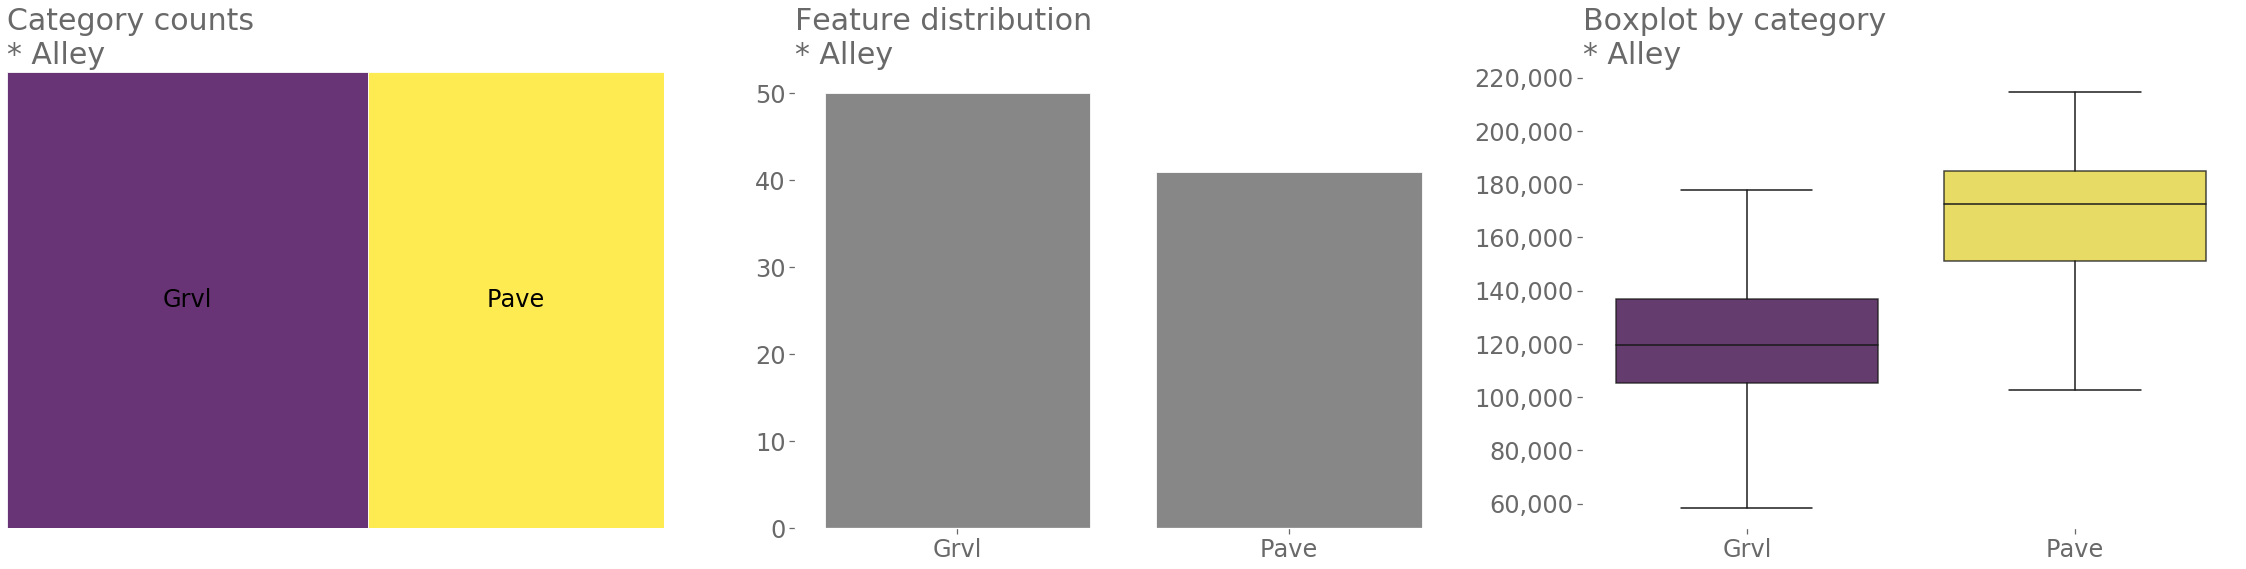

Feature summary Feature vs. target summary 
 
 
 BldgType 
 Count 
 Proportion 
 
 
 
 
 1Fam 
 1220 
 83.561644 
 
 
 TwnhsE 
 114 
 7.808219 
 
 
 Duplex 
 52 
 3.561644 
 
 
 Twnhs 
 43 
 2.945205 
 
 
 2fmCon 
 31 
 2.123288 
 
 
 
 
 
 BldgType 
 Mean 
 Median 
 N 
 StdDev 
 
 
 
 
 1Fam 
 185,763.807377 
 167,900.000000 
 1220 
 82,648.502922 
 
 
 2fmCon 
 128,432.258065 
 127,500.000000 
 31 
 35,458.545158 
 
 
 Duplex 
 133,541.076923 
 135,980.000000 
 52 
 27,833.249197 
 
 
 Twnhs 
 135,911.627907 
 137,500.000000 
 43 
 41,013.222080 
 
 
 TwnhsE 
 181,959.342105 
 172,200.000000 
 114 
 60,626.108918

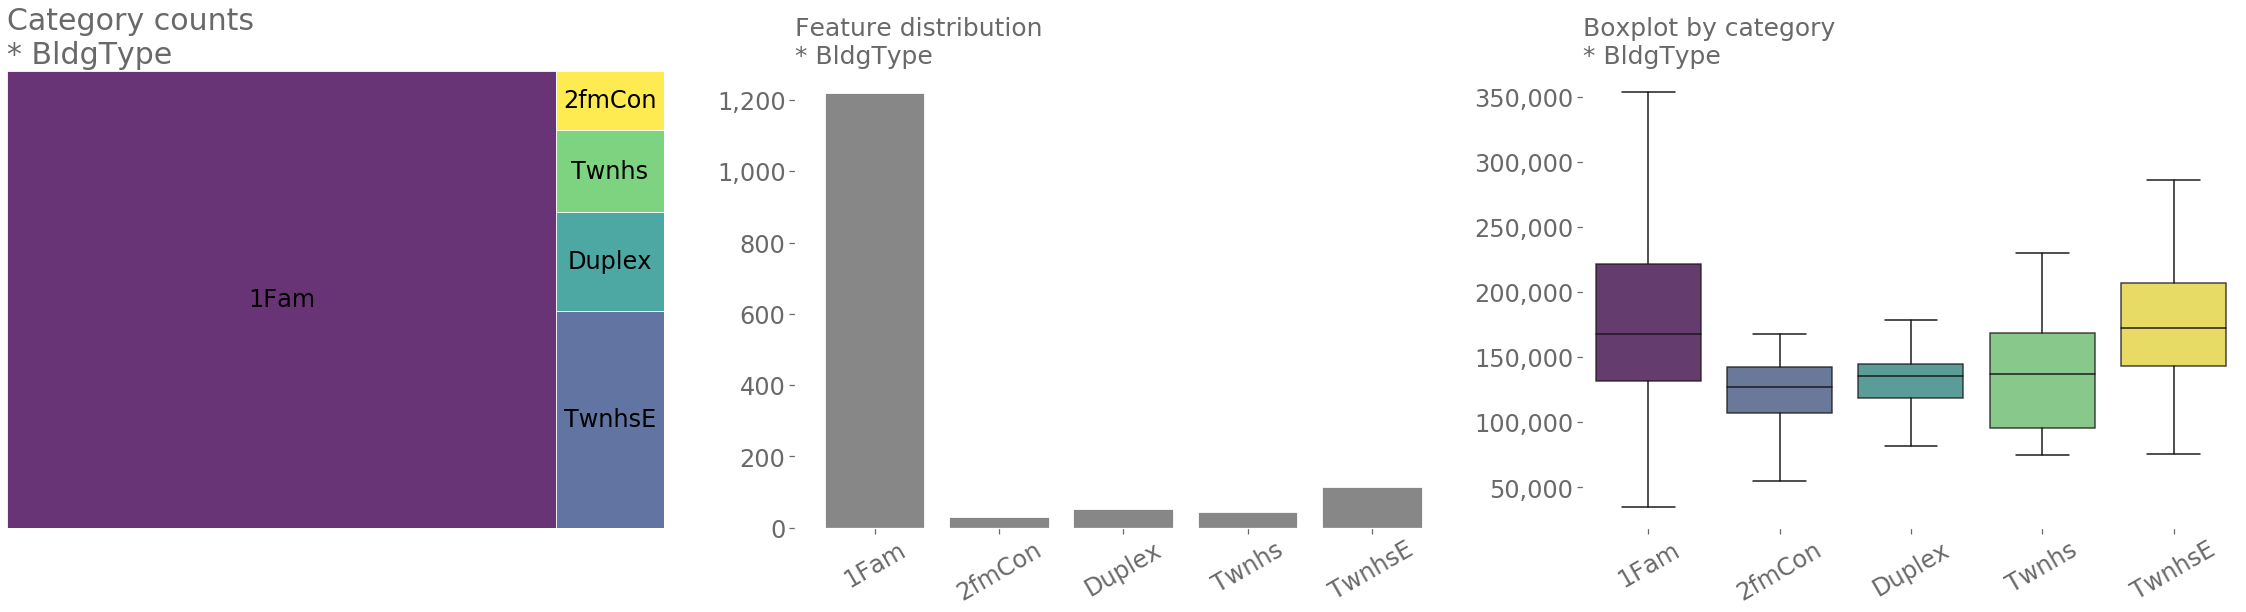

Feature summary Feature vs. target summary 
 
 
 BsmtCond 
 Count 
 Proportion 
 
 
 
 
 TA 
 1311 
 92.129304 
 
 
 Gd 
 65 
 4.567814 
 
 
 Fa 
 45 
 3.162333 
 
 
 Po 
 2 
 0.140548 
 
 
 
 
 
 BsmtCond 
 Mean 
 Median 
 N 
 StdDev 
 
 
 
 
 Fa 
 121,809.533333 
 118,500.000000 
 45 
 43,467.796975 
 
 
 Gd 
 213,599.907692 
 193,879.000000 
 65 
 72,663.155026 
 
 
 Po 
 64,000.000000 
 64,000.000000 
 2 
 4,242.640687 
 
 
 TA 
 183,632.620900 
 165,000.000000 
 1311 
 79,515.388449

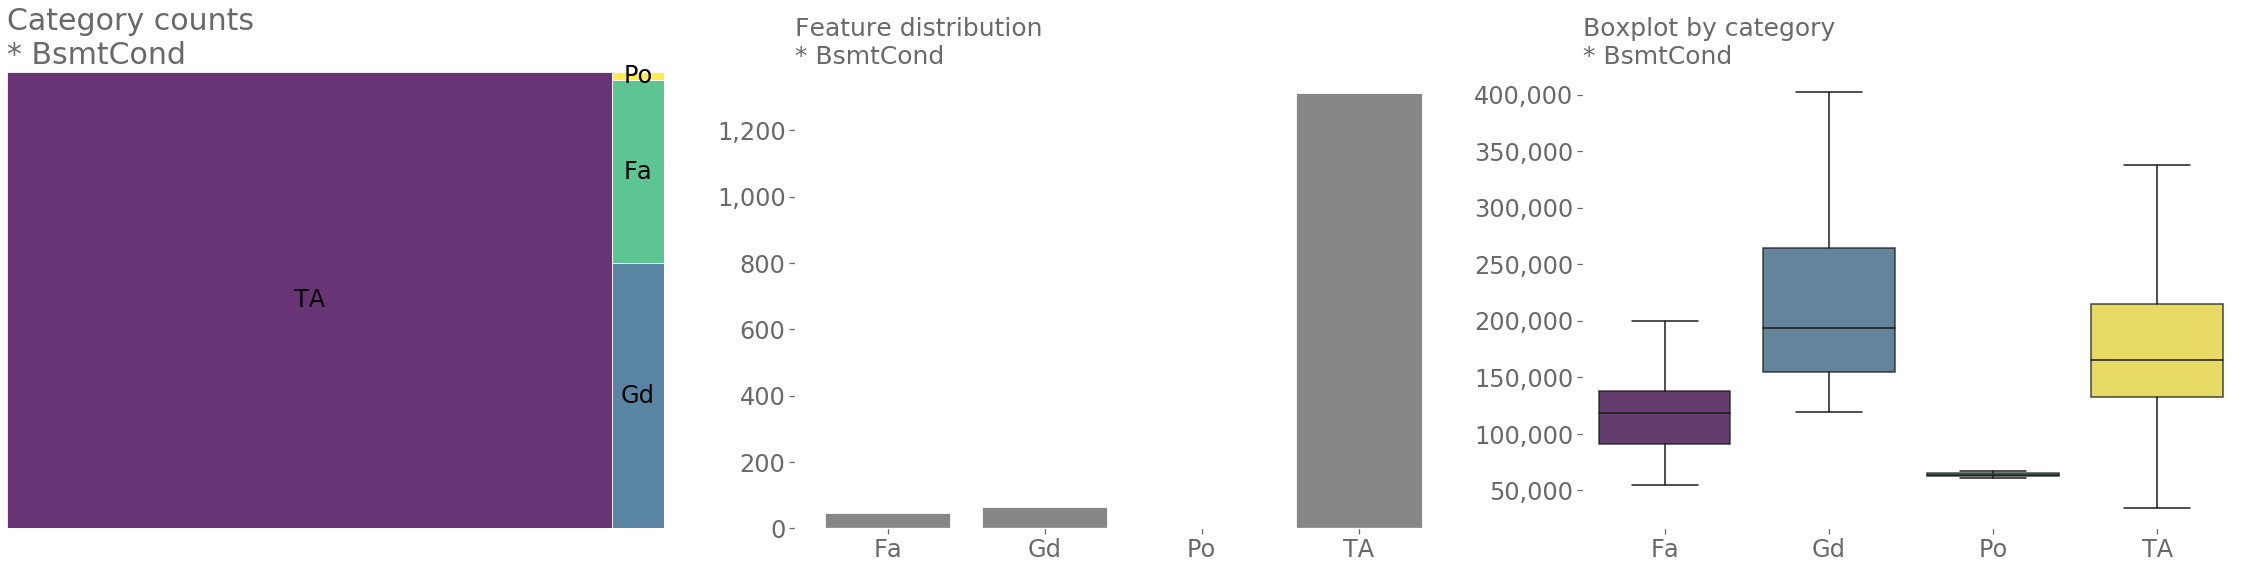

Feature summary Feature vs. target summary 
 
 
 BsmtExposure 
 Count 
 Proportion 
 
 
 
 
 No 
 953 
 67.018284 
 
 
 Av 
 221 
 15.541491 
 
 
 Gd 
 134 
 9.423347 
 
 
 Mn 
 114 
 8.016878 
 
 
 
 
 
 BsmtExposure 
 Mean 
 Median 
 N 
 StdDev 
 
 
 
 
 Av 
 206,643.420814 
 185,850.000000 
 221 
 88,655.504849 
 
 
 Gd 
 257,689.805970 
 226,975.000000 
 134 
 118,923.672583 
 
 
 Mn 
 192,789.657895 
 182,450.000000 
 114 
 77,335.442652 
 
 
 No 
 165,652.295908 
 154,000.000000 
 953 
 60,695.724915

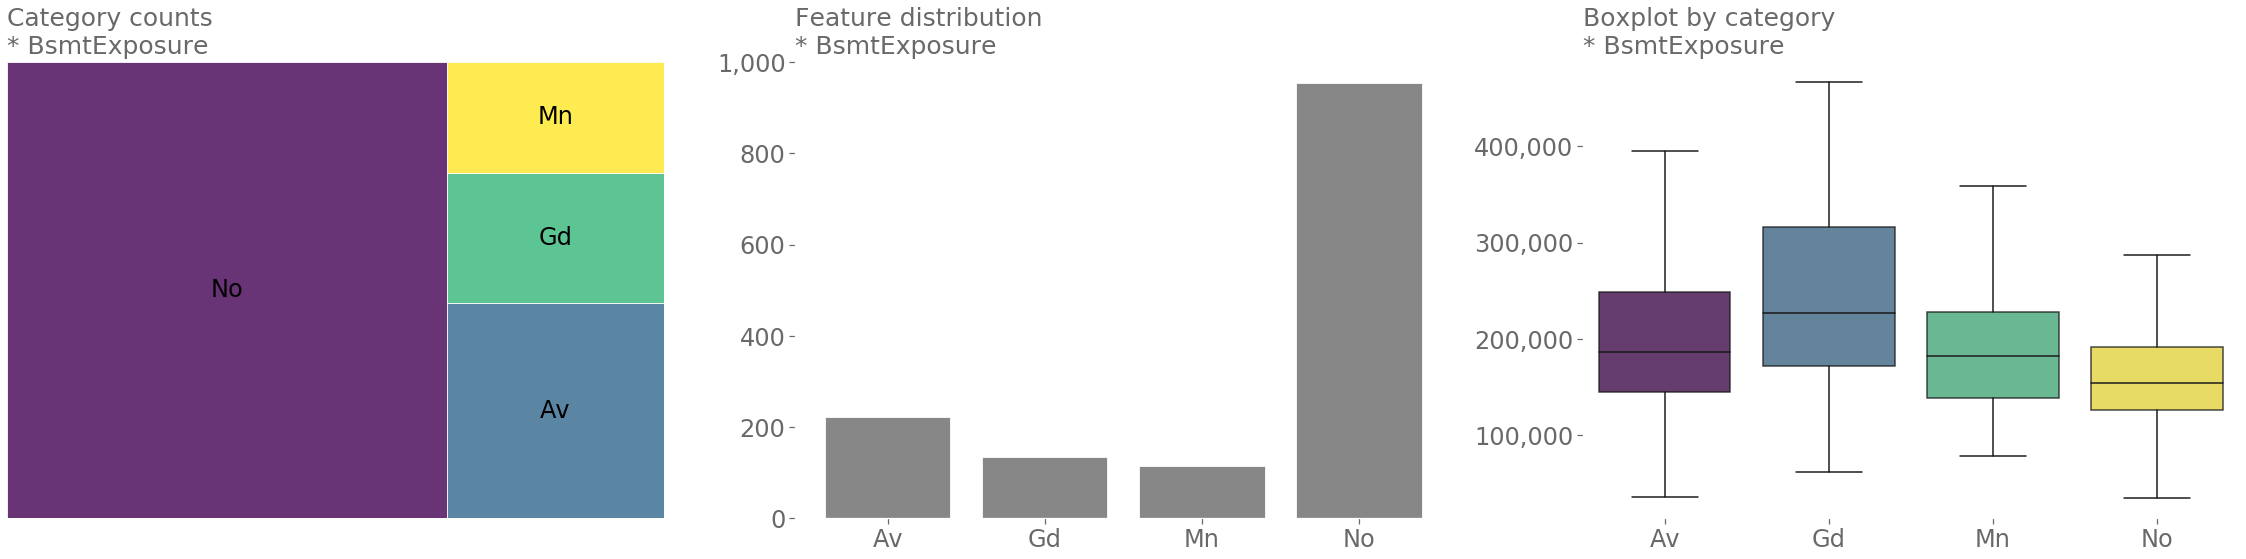

Feature summary Feature vs. target summary 
 
 
 BsmtFinType1 
 Count 
 Proportion 
 
 
 
 
 Unf 
 430 
 30.217850 
 
 
 GLQ 
 418 
 29.374561 
 
 
 ALQ 
 220 
 15.460295 
 
 
 BLQ 
 148 
 10.400562 
 
 
 Rec 
 133 
 9.346451 
 
 
 LwQ 
 74 
 5.200281 
 
 
 
 
 
 BsmtFinType1 
 Mean 
 Median 
 N 
 StdDev 
 
 
 
 
 ALQ 
 161,573.068182 
 149,250.000000 
 220 
 50,821.277231 
 
 
 BLQ 
 149,493.655405 
 139,100.000000 
 148 
 47,327.292126 
 
 
 GLQ 
 235,413.720096 
 213,750.000000 
 418 
 93,215.613258 
 
 
 LwQ 
 151,852.702703 
 139,000.000000 
 74 
 50,796.987083 
 
 
 Rec 
 146,889.248120 
 142,000.000000 
 133 
 45,190.118879 
 
 
 Unf 
 170,670.576744 
 161,750.000000 
 430 
 72,577.080129

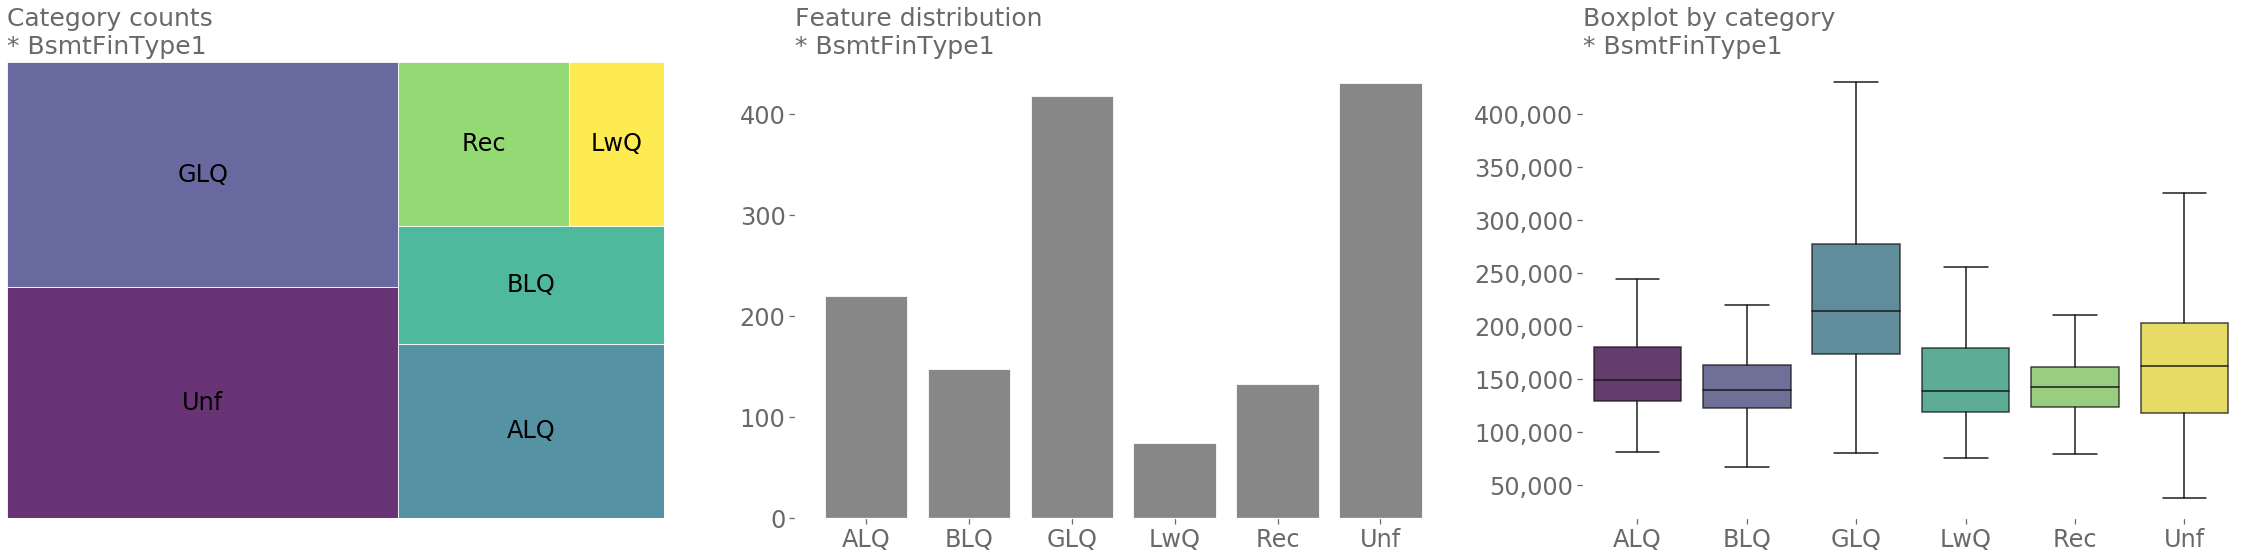

In [8]:
# number features
for feature in train.data.feature_by_mlm_dtype["category"][:5]:
    train.eda_num_target_cat_feat(
        feature=feature,
#         level_count_cap=20,
        chart_scale=20
    )

## Count feature EDA

<a id = 'Count-feature-EDA'></a>

Feature summary Feature vs. target summary 
 
 
 BedroomAbvGr 
 Count 
 Proportion 
 
 
 
 
 3 
 804 
 55.068493 
 
 
 2 
 358 
 24.520548 
 
 
 4 
 213 
 14.589041 
 
 
 1 
 50 
 3.424658 
 
 
 5 
 21 
 1.438356 
 
 
 6 
 7 
 0.479452 
 
 
 0 
 6 
 0.410959 
 
 
 8 
 1 
 0.068493 
 
 
 
 
 
 BedroomAbvGr 
 Mean 
 Median 
 N 
 StdDev 
 
 
 
 
 0 
 221,493.166667 
 202,500.000000 
 6 
 106,675.888935 
 
 
 1 
 173,162.420000 
 145,250.000000 
 50 
 102,975.067584 
 
 
 2 
 158,197.659218 
 137,250.000000 
 358 
 78,197.106241 
 
 
 3 
 181,056.870647 
 169,945.000000 
 804 
 63,793.924903 
 
 
 4 
 220,421.253521 
 193,500.000000 
 213 
 109,510.516383 
 
 
 5 
 180,819.047619 
 161,500.000000 
 21 
 68,472.480743 
 
 
 6 
 143,779.000000 
 141,000.000000 
 7 
 26,455.384839 
 
 
 8 
 200,000.000000 
 200,000.000000 
 1 
 0.000000

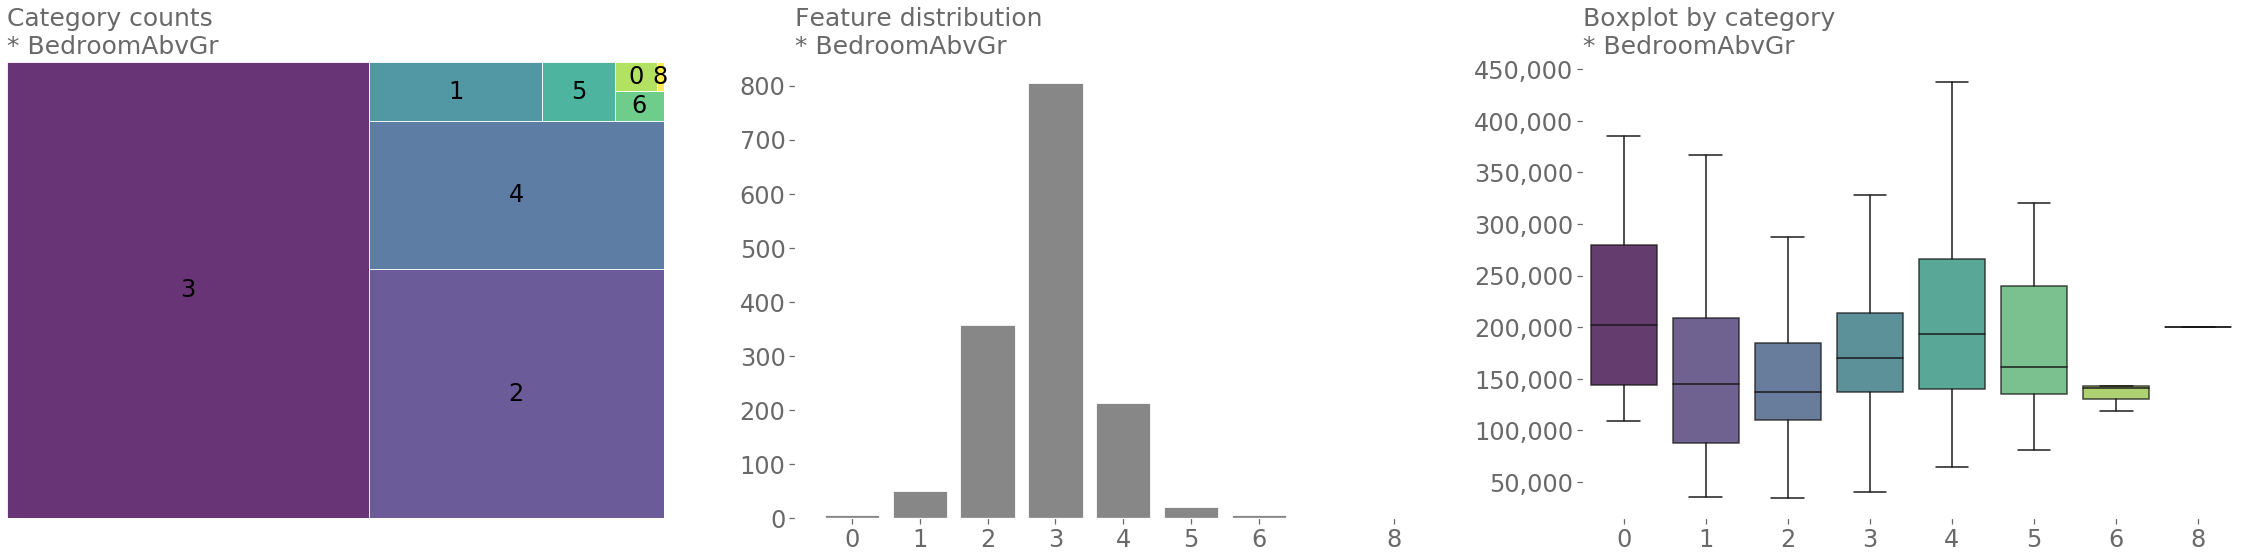

Feature summary Feature vs. target summary 
 
 
 BsmtFullBath 
 Count 
 Proportion 
 
 
 
 
 0 
 856 
 58.630137 
 
 
 1 
 588 
 40.273973 
 
 
 2 
 15 
 1.027397 
 
 
 3 
 1 
 0.068493 
 
 
 
 
 
 BsmtFullBath 
 Mean 
 Median 
 N 
 StdDev 
 
 
 
 
 0 
 165,521.640187 
 154,150.000000 
 856 
 68,137.819610 
 
 
 1 
 202,522.918367 
 178,800.000000 
 588 
 88,895.866415 
 
 
 2 
 213,063.066667 
 188,000.000000 
 15 
 87,308.196346 
 
 
 3 
 179,000.000000 
 179,000.000000 
 1 
 0.000000

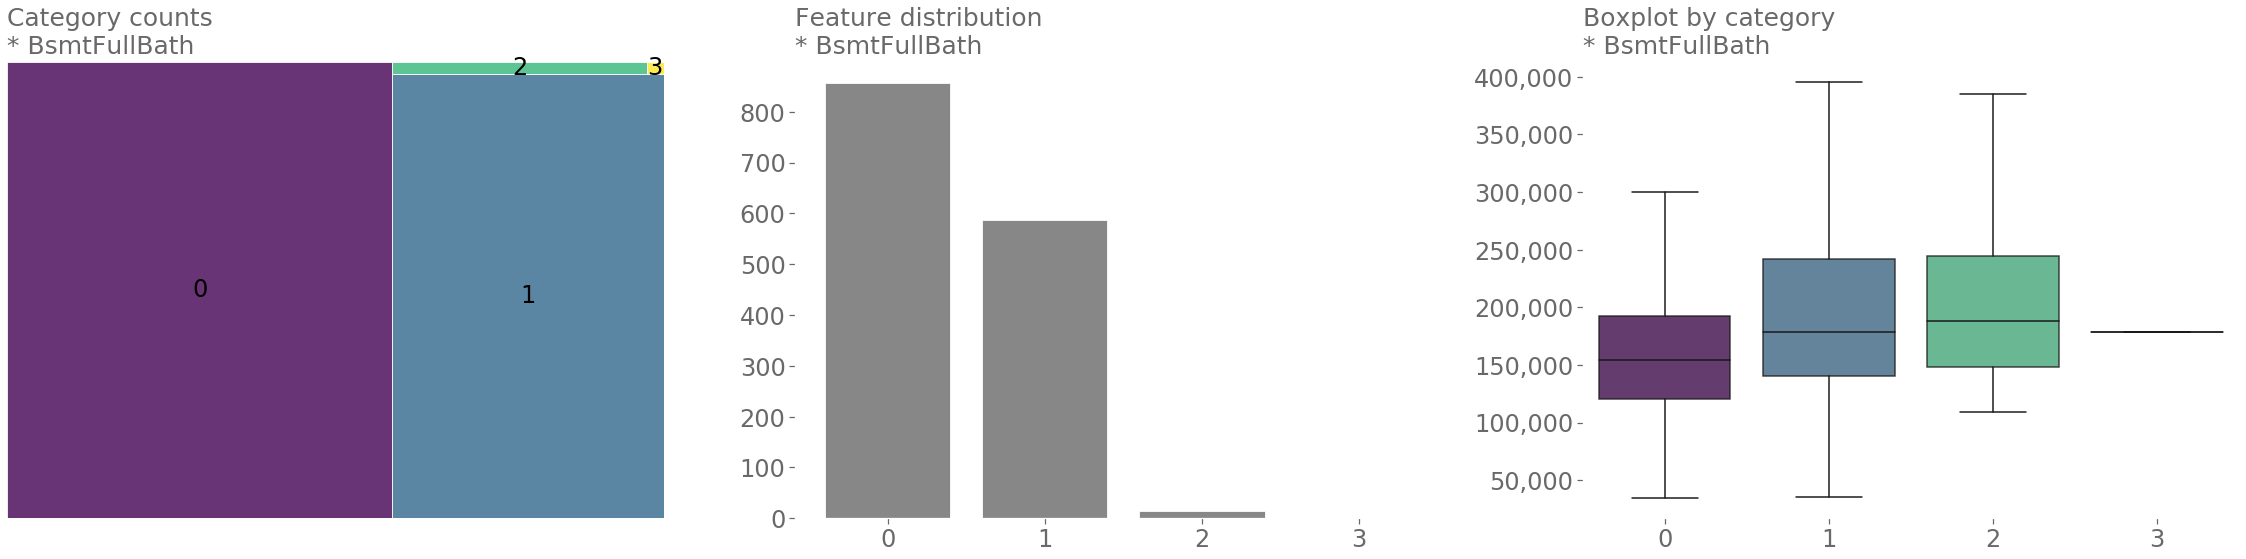

Feature summary Feature vs. target summary 
 
 
 BsmtHalfBath 
 Count 
 Proportion 
 
 
 
 
 0 
 1378 
 94.383562 
 
 
 1 
 80 
 5.479452 
 
 
 2 
 2 
 0.136986 
 
 
 
 
 
 BsmtHalfBath 
 Mean 
 Median 
 N 
 StdDev 
 
 
 
 
 0 
 181,230.330189 
 163,250.000000 
 1378 
 79,303.224623 
 
 
 1 
 176,098.125000 
 159,000.000000 
 80 
 82,901.003355 
 
 
 2 
 160,850.500000 
 160,850.500000 
 2 
 47,164.729412

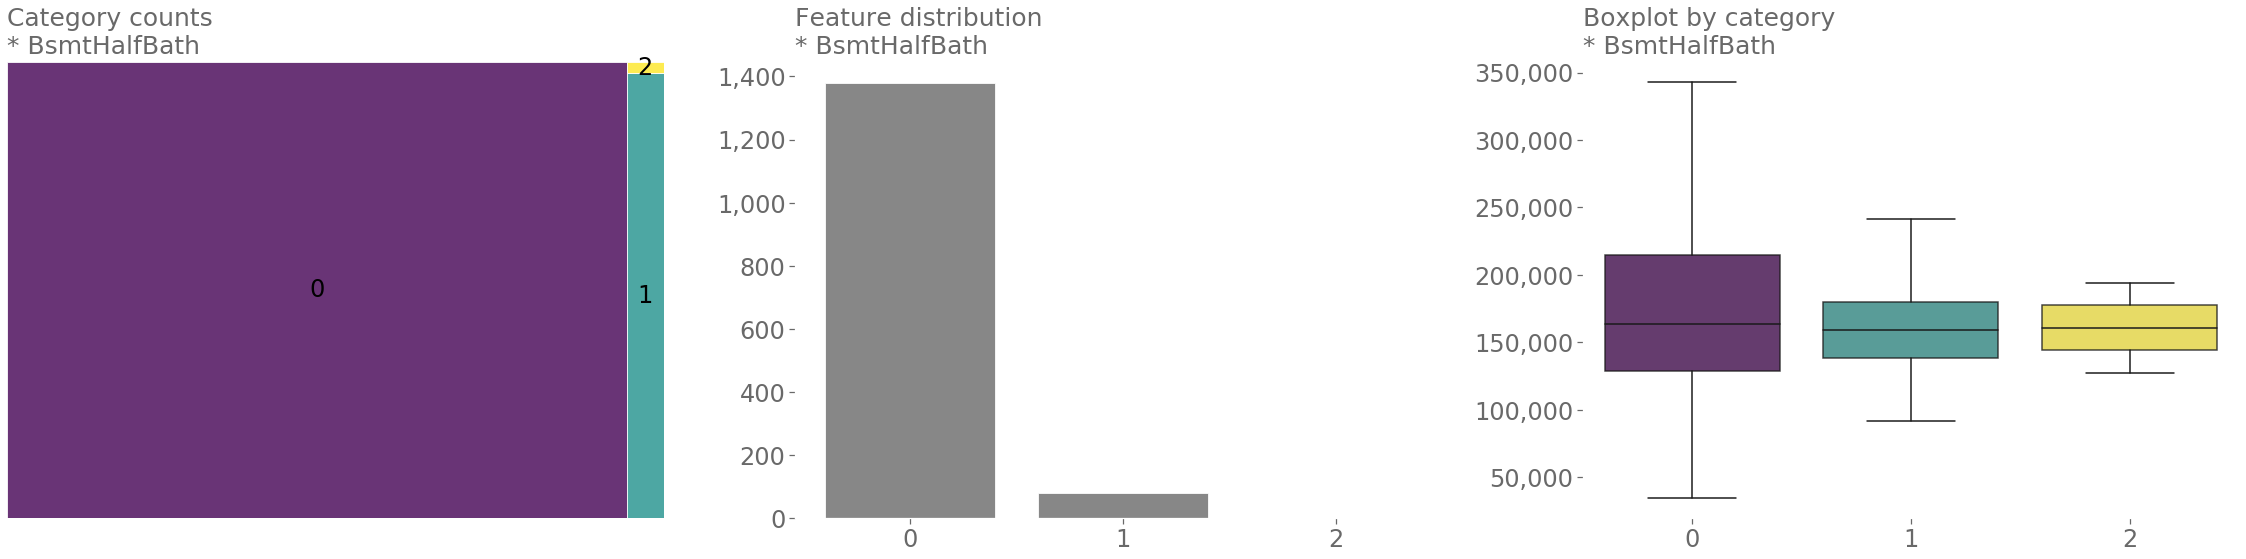

Feature summary Feature vs. target summary 
 
 
 Fireplaces 
 Count 
 Proportion 
 
 
 
 
 0 
 690 
 47.260274 
 
 
 1 
 650 
 44.520548 
 
 
 2 
 115 
 7.876712 
 
 
 3 
 5 
 0.342466 
 
 
 
 
 
 Fireplaces 
 Mean 
 Median 
 N 
 StdDev 
 
 
 
 
 0 
 141,331.482609 
 135,000.000000 
 690 
 44,389.786884 
 
 
 1 
 211,843.909231 
 189,975.000000 
 650 
 79,531.825318 
 
 
 2 
 240,588.539130 
 206,900.000000 
 115 
 117,451.800525 
 
 
 3 
 252,000.000000 
 205,000.000000 
 5 
 93,313.986090

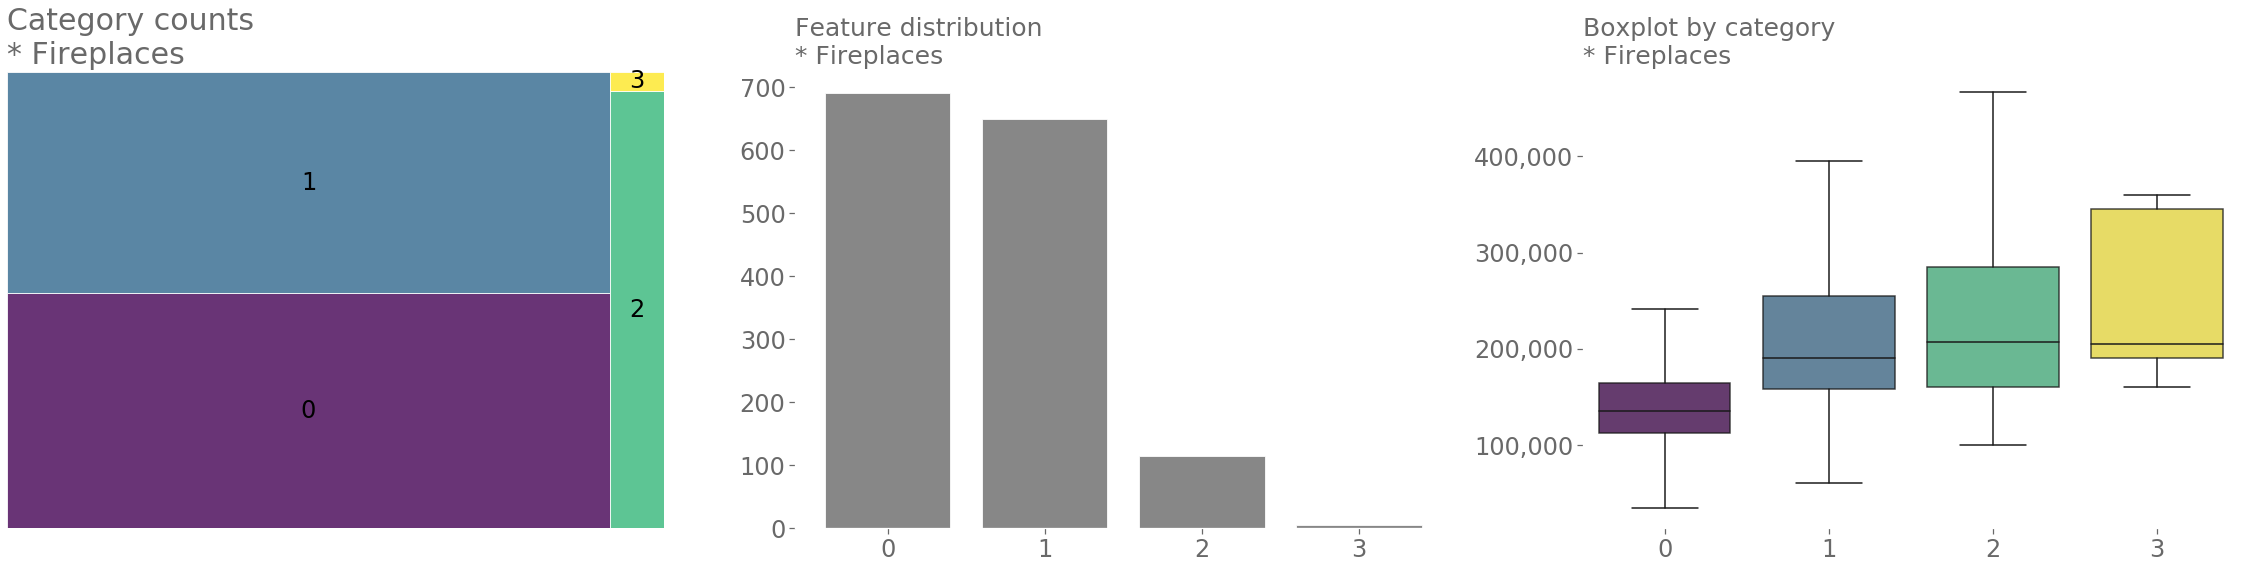

Feature summary Feature vs. target summary 
 
 
 FullBath 
 Count 
 Proportion 
 
 
 
 
 2 
 768 
 52.602740 
 
 
 1 
 650 
 44.520548 
 
 
 3 
 33 
 2.260274 
 
 
 0 
 9 
 0.616438 
 
 
 
 
 
 FullBath 
 Mean 
 Median 
 N 
 StdDev 
 
 
 
 
 0 
 165,200.888889 
 145,000.000000 
 9 
 106,083.806001 
 
 
 1 
 134,751.440000 
 132,375.000000 
 650 
 41,565.080488 
 
 
 2 
 213,009.825521 
 196,750.000000 
 768 
 72,446.809159 
 
 
 3 
 347,822.909091 
 320,000.000000 
 33 
 165,185.455377

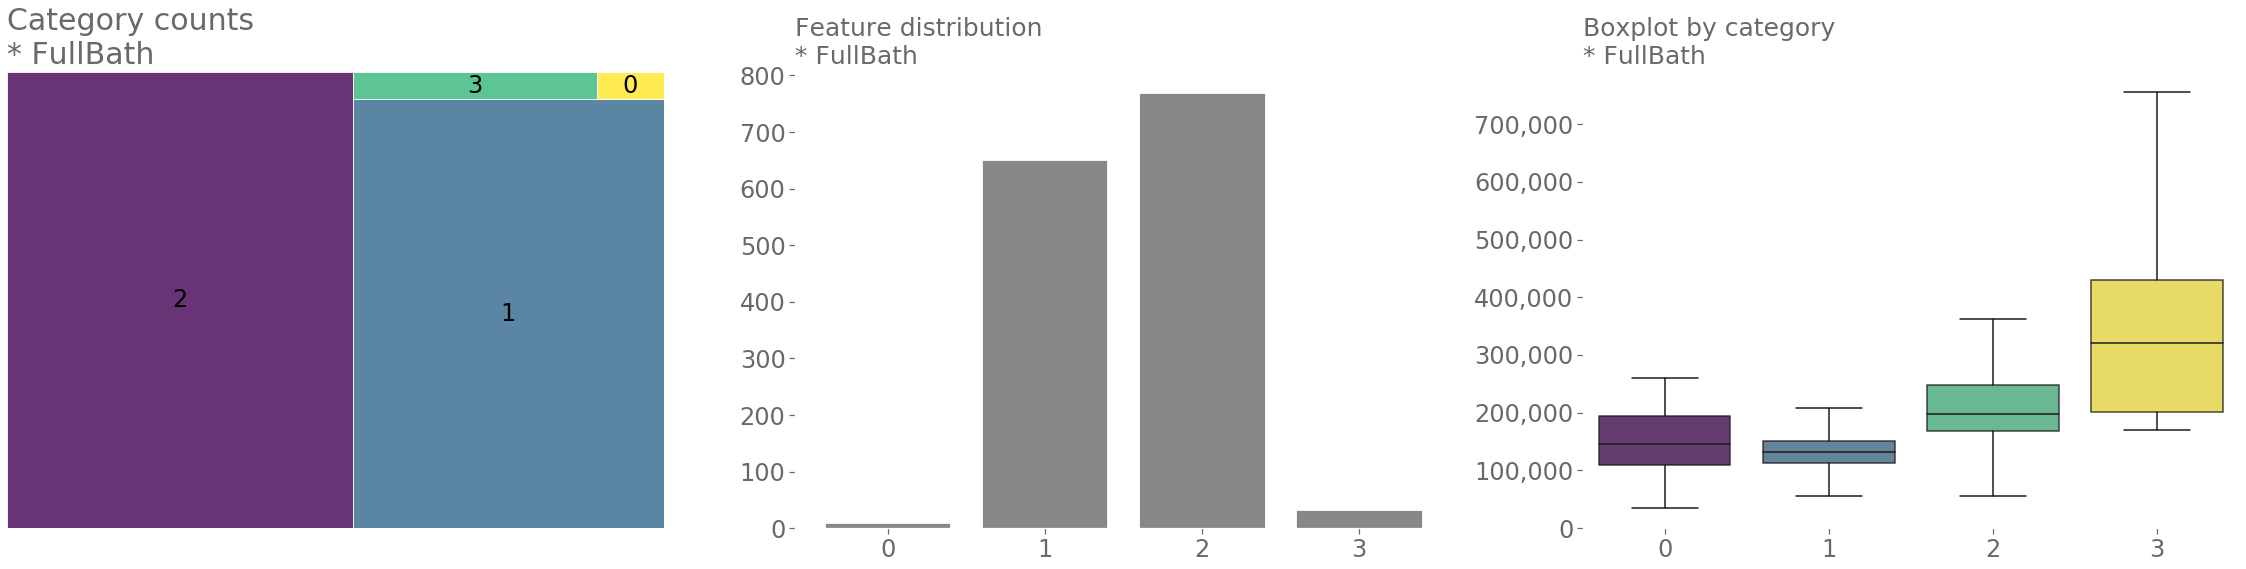

In [9]:
# number features
for feature in train.data.feature_by_mlm_dtype["count"][:5]:
    train.eda_num_target_cat_feat(
        feature=feature,
#         level_count_cap=20,
        chart_scale=20
    )

## Continuous feature EDA

<a id = 'Continuous-feature-EDA'></a>

,,1stFlrSF
0,count,"1,460.000000"
1,mean,"1,162.626712"
2,std,386.587738
3,min,334.000000
4,25%,882.000000
5,50%,"1,087.000000"
6,75%,"1,391.250000"
7,max,"4,692.000000"
8,skew,1.375342
9,kurtosis,5.722076


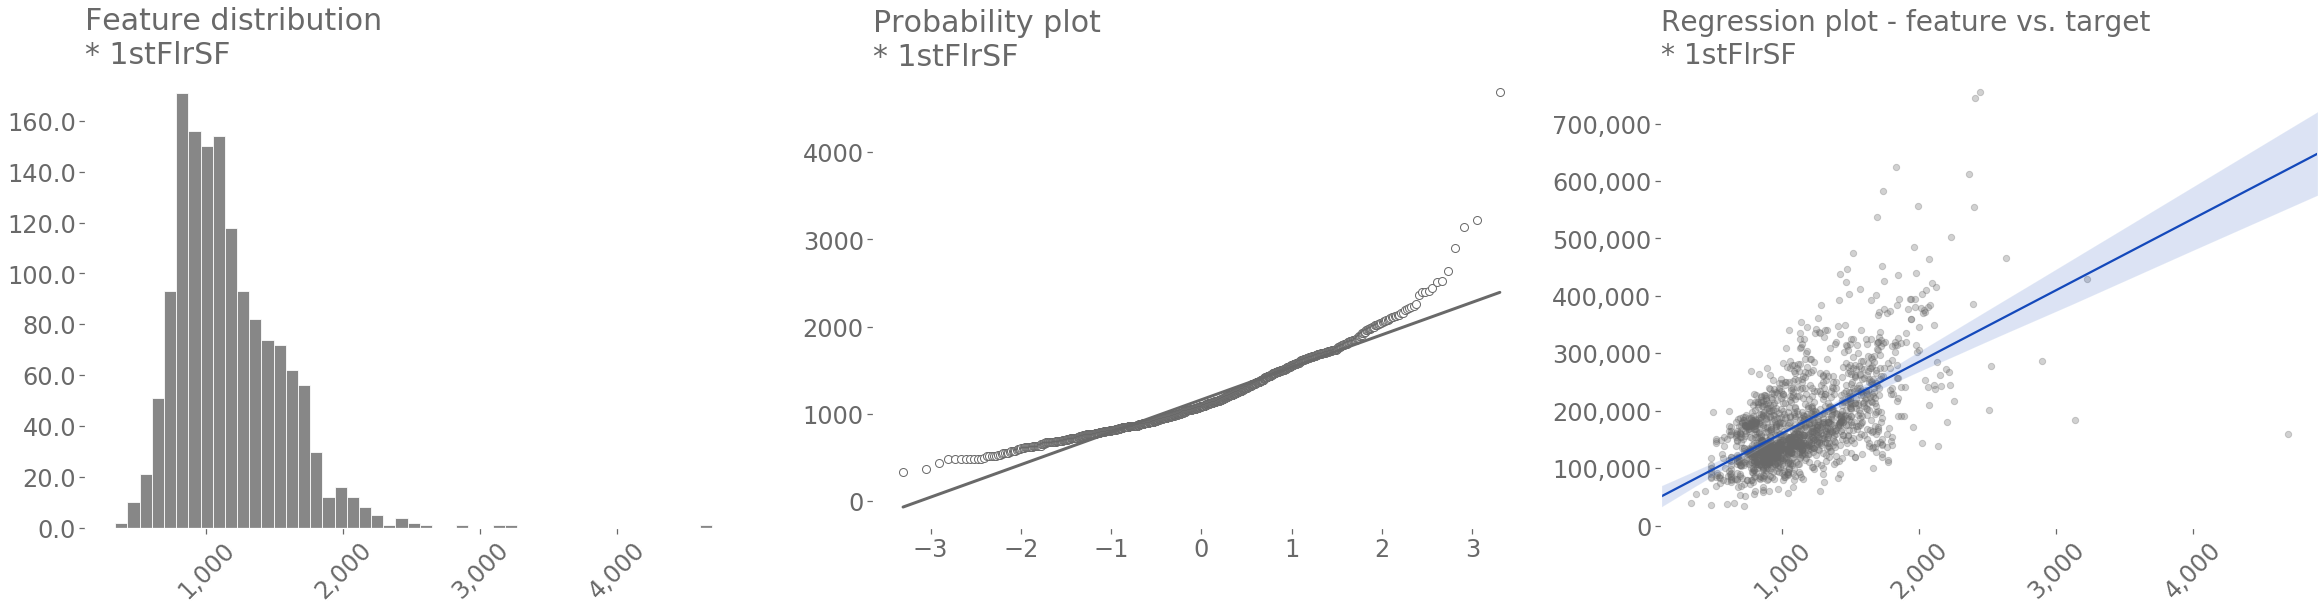

,,2ndFlrSF
0,count,"1,460.000000"
1,mean,346.992466
2,std,436.528436
3,min,0.000000
4,25%,0.000000
5,50%,0.000000
6,75%,728.000000
7,max,"2,065.000000"
8,skew,0.812194
9,kurtosis,-0.555677


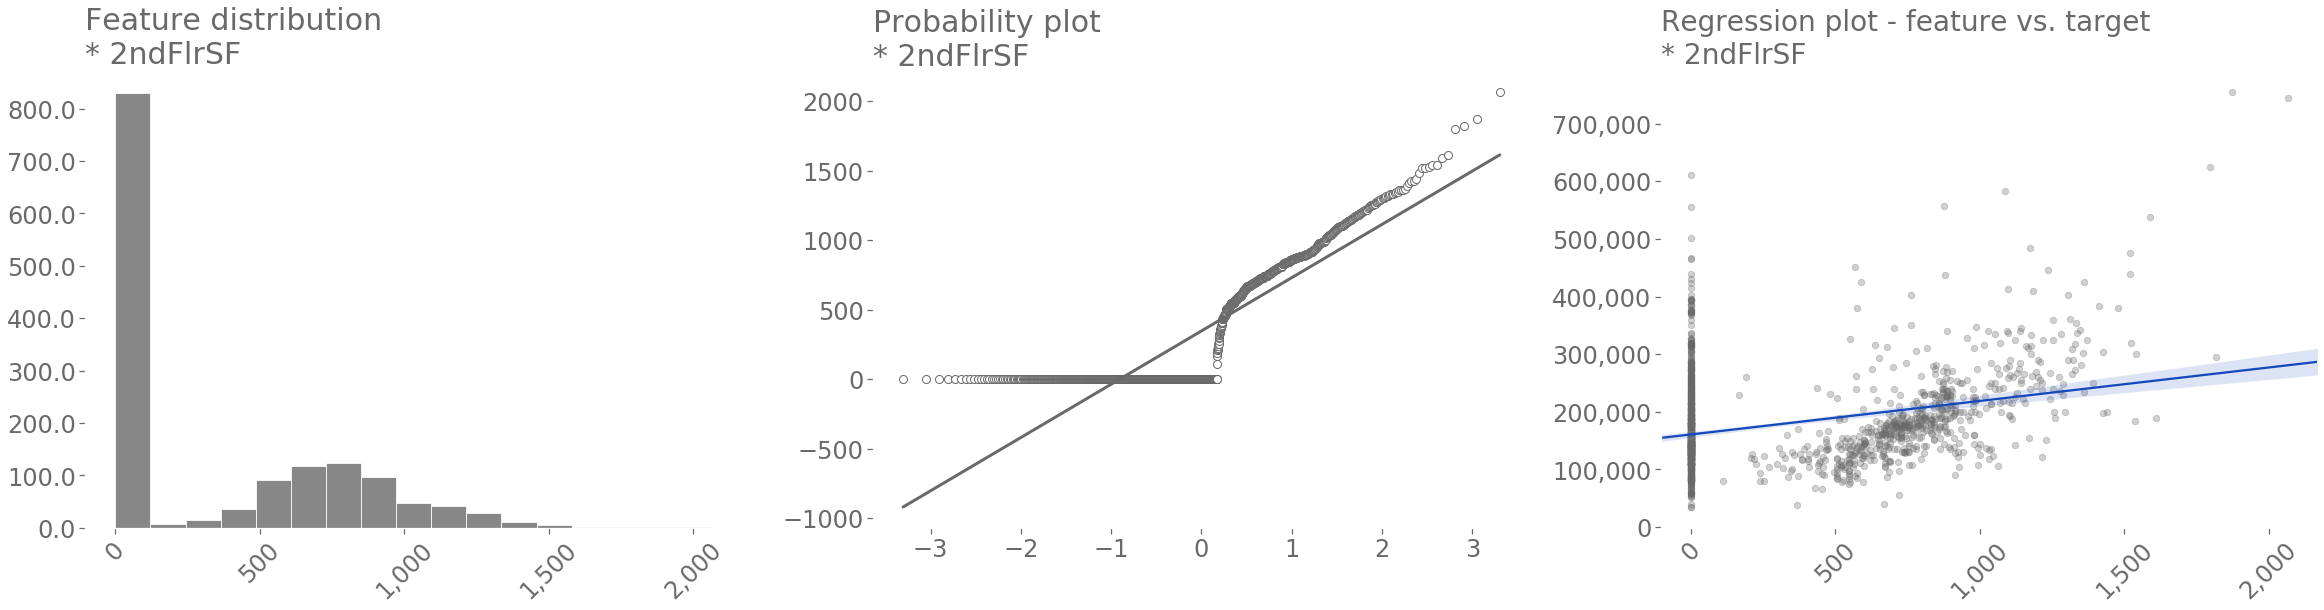

,,3SsnPorch
0,count,"1,460.000000"
1,mean,3.409589
2,std,29.317331
3,min,0.000000
4,25%,0.000000
5,50%,0.000000
6,75%,0.000000
7,max,508.000000
8,skew,10.293752
9,kurtosis,123.235177


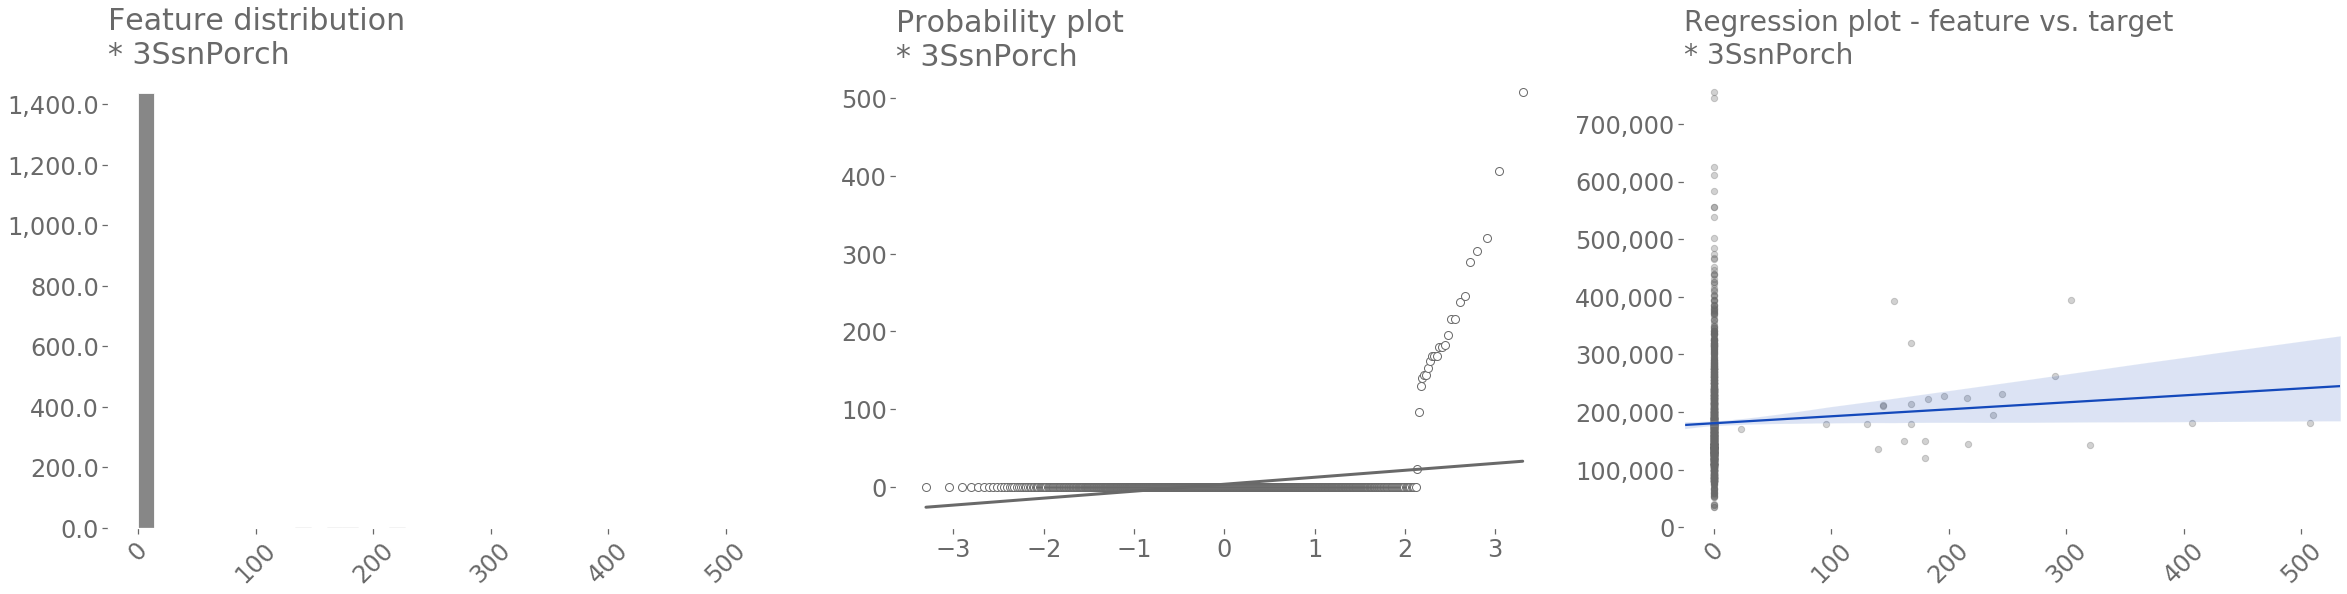

In [10]:
# continuous features
for feature in train.data.feature_by_mlm_dtype["continuous"][:3]:
    train.eda_num_target_num_feat(
        feature=feature,
#         outliers_out_of_scope=5,
        chart_scale=20
    )

##### Correlation

In [ ]:
# # correlation heat map
# p = PrettierPlot(chart_scale=25)
# ax = p.make_canvas()
# p.corr_heatmap(df=train.data, ax=ax)

In [ ]:
# # correlation heat map with most highly correlated features relative to the target
# p = PrettierPlot(plot_orientation='tall',chart_scale=15)
# ax = p.make_canvas()
# p.corr_heatmap_target(df=train.data, target=train.target, thresh=0.6, annot = True, ax=ax)

> Remarks - There are three pairs of highly correlated features:
    - 'GarageArea' and 'GarageCars'
    - 'TotRmsAbvGrd' and 'GrLivArea'
    - '1stFlrSF' and 'TotalBsmtSF
This makes sense, given what each feature represents and how each pair items relate to each other. We likely only need one feature from each pair.

##### Pair plot

In [ ]:
# # pair plot
# p = PrettierPlot(chart_scale=10)
# p.pair_plot(
#     df=train.data,
#     columns=[
#         "LotFrontage",
#         "LotArea",
#         "MasVnrArea",
#         "BsmtFinSF1",
#         "BsmtFinSF2",
#         "BsmtUnfSF",
#         "TotalBsmtSF",
#         "1stFlrSF",
#         "2ndFlrSF",
#         "GrLivArea",
#         "TotRmsAbvGrd",
#         "GarageYrBlt",
#         "GarageArea",
#         "WoodDeckSF",
#         "OpenPorchSF",
#     ],
#     diag_kind="auto",
# )

## Faceting

<a id = 'Faceting'></a>

## Target variable evaluation

<a id = 'Target-variable-evaluation'></a>

In [ ]:
# evaluate distribution of target variable
train.eda_transform_initial(data=train.target, name=train.target.name)
train.eda_transform_log1(data=train.target, name=train.target.name)

In [ ]:
# log + 1 transform target
train.target = np.log1p(train.target)

# Data preparation

<a id = 'Data-preparation'></a>

## Missing data


<a id = 'Missing-data'></a>

##### Training

In [ ]:
# evaluate missing data
train.eda_missing_summary(chart_scale=25)

In [ ]:
# missingno matrix
# msno.matrix(train.data)

In [ ]:
# missingno bar
# msno.bar(train.data)

In [ ]:
# missingno heatmap
# msno.heatmap(train.data)

In [ ]:
# missingno dendrogram
# msno.dendrogram(train.data)

##### Validation

In [ ]:
# evaluate missing data
valid.eda_missing_summary()

In [ ]:
# missingno matrix
# msno.matrix(valid.data)

In [ ]:
# missingno bar
# msno.bar(valid.data)

In [ ]:
# missingno heatmap
# msno.heatmap(valid.data)

In [ ]:
# missingno dendrogram
# msno.dendrogram(valid.data)

##### Training vs. validation


In [ ]:
# compare feature with missing data
train.missing_col_compare(train=train.data, validation=valid.data)

##### Impute


In [ ]:
# impute pipeline
category_constant = ['GarageFinish', 'Alley', 'MasVnrType', 'GarageType', 'BsmtFinType1',
                       'BsmtCond', 'BsmtFinType2', 'BsmtQual', 'PoolQC', 'GarageCond',
                       'FireplaceQu', 'GarageQual', 'Fence', 'BsmtExposure', 'MiscFeature']
number_constant = ["GarageYrBlt","MasVnrArea","BsmtUnfSF","GarageArea","BsmtFinSF1","TotalBsmtSF","BsmtFinSF2"]
category_mode = ["Electrical","Functional","SaleType","Exterior1st","MSZoning","Exterior2nd","KitchenQual","Utilities"]
number_mode = ["BsmtHalfBath", "GarageCars", "BsmtFullBath"]

impute_pipe = PandasFeatureUnion([
    ("catConstant", pipeline.make_pipeline(
        DataFrameSelector(include_columns=category_constant),
        PandasPipeline(impute.SimpleImputer(strategy="constant", fill_value="Nonexistent"))
    )),
    ("numConstant", pipeline.make_pipeline(
        DataFrameSelector(include_columns=number_constant),
        PandasPipeline(impute.SimpleImputer(strategy="constant", fill_value=0))
    )),
    ("catMode", pipeline.make_pipeline(
        DataFrameSelector(include_columns=category_mode),
        PandasPipeline(impute.SimpleImputer(strategy="most_frequent"))
    )),
    ("numMode", pipeline.make_pipeline(
        DataFrameSelector(include_columns=number_mode),
        PandasPipeline(impute.SimpleImputer(strategy="most_frequent"))
    )),
    ("LotFrontage", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["LotFrontage","Neighborhood"]),
        ContextImputer(null_col="LotFrontage", context_col="Neighborhood", strategy="mean")
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_columns=["LotFrontage"] + category_constant + number_constant + category_mode + number_mode),
    )),
])

train.data = impute_pipe.fit_transform(train.data)
valid.data = impute_pipe.transform(valid.data)

In [ ]:
train.eda_missing_summary()

In [ ]:
valid.eda_missing_summary()

## Feature engineering

<a id = 'Feature-engineering'></a>

### Handcrafted

<a id = 'Handcrafted'></a>

In [ ]:
# additional features
train.data["BsmtFinSF"] = train.data["BsmtFinSF1"] + train.data["BsmtFinSF2"]
train.data["TotalSF"] = (
    train.data["TotalBsmtSF"] + train.data["1stFlrSF"] + train.data["2ndFlrSF"]
)
train.update_feature_by_mlm_dtype()

In [ ]:
# # evaluate additional features
# for feature in ["BsmtFinSF","TotalSF"]:
#     train.eda_num_target_num_feat(
#         feature=feature,
# #         outliers_out_of_scope=5,
#         chart_scale=20
#     )

In [ ]:
# additional features
valid.data["BsmtFinSF"] = valid.data["BsmtFinSF1"] + valid.data["BsmtFinSF2"]
valid.data["TotalSF"] = (
    valid.data["TotalBsmtSF"] + valid.data["1stFlrSF"] + valid.data["2ndFlrSF"]
)
valid.update_feature_by_mlm_dtype()

### Polynomial features

<a id = 'Polynomial-features'></a>

In [ ]:
# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["TotalSF","BsmtFinSF"]),
        #DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasPipeline(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_columns=["TotalSF","BsmtFinSF"]),
        #DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_feature_by_mlm_dtype()
valid.update_feature_by_mlm_dtype()

### Encoding

<a id = 'Encoding'></a>

In [ ]:
# counts of unique values in training data object columns
train.data[train.data.feature_by_mlm_dtype["category"]].apply(pd.Series.nunique, axis=0)

In [ ]:
# print unique values in each object columns
for col in train.data.feature_by_mlm_dtype["category"]:
    print(col, np.unique(train.data[col]))

In [ ]:
# counts of unique values in validation data string columns
valid.data[valid.data.feature_by_mlm_dtype["category"]].apply(pd.Series.nunique, axis=0)

In [ ]:
# print unique values in each object columns
for col in valid.data.feature_by_mlm_dtype["category"]:
    print(col, np.unique(valid.data[col]))

In [ ]:
# identify values that are present in the training data but not the validation data, and vice versa
for col in train.data.feature_by_mlm_dtype["category"]:
    train_values = train.data[col].unique()
    valid_values = valid.data[col].unique()

    train_diff = set(train_values) - set(valid_values)
    valid_diff = set(valid_values) - set(train_values)

    if len(train_diff) > 0 or len(valid_diff) > 0:
        print("\n\n*** " + col)
        print("Value present in training data, not in validation data")
        print(train_diff)
        print("Value present in validation data, not in training data")
        print(valid_diff)

In [ ]:
train.data["MSSubClass"]

In [ ]:
# nominal columns
nominal_columns = [
    "MSSubClass",
    "MSZoning",
    "LandContour",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "Heating",
    "GarageType",
    "Fence",
    "SaleType",
    "SaleCondition",
    "MiscFeature",
]

ordinal_encoding = {
    "Street": ["Grvl", "Pave"],  #  
    "Alley": ["Nonexistent", "Grvl", "Pave"],  # 
    "LotShape": ["IR3", "IR2", "IR1", "Reg"],  # 
    "Utilities": ["ELO", "NoSeWa", "NoSewr", "AllPub"],  # 
    "LotConfig": ["FR3", "FR2", "Corner", "Inside", "CulDSac"],  # 
    "LandSlope": ["Sev", "Mod", "Gtl"],  # 
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],  # 
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],  # 
    "BsmtQual": ["Nonexistent", "Po", "Fa", "TA", "Gd", "Ex"],  # 
    "BsmtCond": ["Nonexistent", "Po", "Fa", "TA", "Gd", "Ex"],  # 
    "BsmtExposure": ["Nonexistent", "No", "Mn", "Av", "Gd"],  # 
    "BsmtFinType1": ["Nonexistent", "Unf", "LwQ", "BLQ", "Rec", "ALQ", "GLQ"],  # 
    "BsmtFinType2": ["Nonexistent", "Unf", "LwQ", "BLQ", "Rec", "ALQ", "GLQ"],  # 
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],  # 
    "CentralAir": ["N", "Y"],  # 
    "Electrical": ["FuseP", "FuseF", "FuseA", "Mix", "SBrkr"],  # 
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],  # 
    "Functional": ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],  # 
    "FireplaceQu": ["Nonexistent", "Po", "Fa", "TA", "Gd", "Ex"],  # 
    "GarageFinish": ["Nonexistent", "Unf", "RFn", "Fin"],  # 
    "GarageQual": ["Nonexistent", "Po", "Fa", "TA", "Gd", "Ex"],  # 
    "GarageCond": ["Nonexistent", "Po", "Fa", "TA", "Gd", "Ex"],  # 
    "PavedDrive": ["N", "P", "Y"],  # 
    "PoolQC": ["Nonexistent", "Fa", "TA", "Gd", "Ex"],  # 
}

# encode pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", pipeline.make_pipeline(
        DataFrameSelector(include_columns=nominal_columns),
        PandasPipeline(preprocessing.OneHotEncoder(drop="first")),
    )),
    ("ordinal", pipeline.make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encoding.keys())),
        PandasPipeline(preprocessing.OrdinalEncoder(categories=list(ordinal_encoding.values()))),
    )),
    ("bin", pipeline.make_pipeline(
        DataFrameSelector(include_columns=train.data.feature_by_mlm_dtype["continuous"]),
        PandasPipeline(preprocessing.KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_columns=nominal_columns + list(ordinal_encoding.keys())),
    )),
])

train.data = encode_pipe.fit_transform(train.data)
# valid.data = encode_pipe.transform(valid.data)

train.update_feature_by_mlm_dtype()
# valid.update_feature_by_mlm_dtype()

In [ ]:
train.data[:10]

In [ ]:
train.data.feature_by_mlm_dtype

In [ ]:
train.data[:10]

In [ ]:
# target encoding pipe
target_encode_pipe = PandasFeatureUnion([
    ("target", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=ce.TargetEncoder,
        ),
    )),
    ("woe", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=ce.WOEEncoder,
        ),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

train.data = target_encode_pipe.fit_transform(train.data)
valid.data = target_encode_pipe.transform(valid.data)

train.update_feature_by_mlm_dtype()
valid.update_feature_by_mlm_dtype()

## Feature transformation

<a id = 'Feature-transformation'></a>

### Skew correction


<a id = 'Skew-correction'></a>

In [ ]:
# evaluate skew of number features - validation data
train.skew_summary()

In [ ]:
# evaluate skew of number features - training data
valid.skew_summary()

In [ ]:
# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        DualTransformer(),
    )),    
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

train.data = skew_pipe.fit_transform(train.data)
valid.data = skew_pipe.transform(valid.data)

train.update_feature_by_mlm_dtype()
valid.update_feature_by_mlm_dtype()

### Scaling


<a id = 'Scaling'></a>

In [ ]:
#
scale_pipe = PandasFeatureUnion([
    ("scale", pipeline.make_pipeline(
        DataFrameSelector(),
        PandasPipeline(preprocessing.RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_feature_by_mlm_dtype()
valid.update_feature_by_mlm_dtype()

## Outliers

<a id = 'Outliers'></a>

In [ ]:
# identify outliers using IQR
train_pipe = pipeline.Pipeline([
    ("outlier",train.OutlierIQR(
                outlier_count=20,
                iqr_step=1.5,
                features=train.data.feature_by_mlm_dtype["number"],
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
iqr_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers_))
print(iqr_outliers)

In [ ]:
# identify outliers using Isolation Forest
clf = ensemble.IsolationForest(
    behaviour="new", max_samples=train.data.shape[0], random_state=0, contamination=0.01
)
clf.fit(train.data[train.data.columns])
preds = clf.predict(train.data[train.data.columns])

# evaluate index values
mask = np.isin(preds, -1)
if_outliers = np.array(train.data[mask].index)
print(if_outliers)

In [ ]:
# identify outliers using extended isolation forest
train_pipe = pipeline.Pipeline([
    ("outlier",train.ExtendedIsoForest(
                columns=train.data.feature_by_mlm_dtype["number"],
                n_trees=100,
                sample_size=256,
                extension_level=1,
                anomalies_ratio=0.03,
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
eif_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers_))
print(eif_outliers)

In [ ]:
# identify outliers that are identified in multiple algorithms
outliers = reduce(np.intersect1d, (iqr_outliers, if_outliers, eif_outliers))
# outliers = reduce(np.intersect1d, (if_outliers, eif_outliers))
print(outliers)

In [ ]:
# review outlier identification summary
outlier_summary = train.outlier_summary(iqr_outliers=iqr_outliers,
                             if_outliers=if_outliers,
                             eif_outliers=eif_outliers
                            )
outlier_summary[outlier_summary["count"] >= 3]

In [ ]:
# capture index values of known outliers
knownOutliers = (
    train.data[train.data["LotArea"] > 60000].index.values.tolist()
    + train.data[train.data["LotFrontage"] > 300].index.values.tolist()
    + train.data[train.data["GrLivArea"] > 4000].index.values.tolist()
)
knownOutliers = sorted(set(knownOutliers))
print(knownOutliers)

# index of known outliers and outliers identified with the known outliers removed
outliers = [
    53,
    185,
    197,
    437,
    492,
    762,
    796,
    821,
    847,
    1161,
    1221,
    1318,
    1376,
    249,
    313,
    335,
    451,
    523,
    691,
    706,
    934,
    1182,
    1298,
]
print(outliers)

# remove outlers from predictors and response
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

print(train.data.shape)
print(train.target.shape)

## Additional exploratory data analysis

<a id = 'Additional-exploratory-data-analysis'></a>

# Feature importance

<a id = 'Feature-importance'></a>

In [ ]:
# generate feature importance summary
estimators = [
    lightgbm.LGBMRegressor,
#     ensemble.RandomForestRegressor,
#     ensemble.GradientBoostingRegressor,
#     ensemble.ExtraTreesRegressor,
#     ensemble.AdaBoostRegressor,
#     xgboost.XGBRegressor,
]

fs = train.FeatureSelector(
    data=train.data,
    target=train.target,
    estimators=estimators,
    classification=False,
)
feature_selector_summary = fs.feature_selector_suite(save_to_csv=True, n_jobs=16)
feature_selector_summary[:20]

In [ ]:
# calculate cross-validation performance
estimators = [
    svm.SVR,
    lightgbm.LGBMRegressor,
    xgboost.XGBRegressor,
    ensemble.RandomForestRegressor,
    ensemble.GradientBoostingRegressor,
    ensemble.AdaBoostRegressor,
    ensemble.ExtraTreesRegressor,
    neighbors.KNeighborsRegressor,
]

cv_summary = fs.feature_selector_cross_val(
    estimators=estimators,
    feature_selector_summary=feature_selector_summary,
    estimators=estimators,
    scoring=["root_mean_squared_error"],
    n_folds=8,
    step=1,
    n_jobs=16,
)

###### Mean squared error

In [ ]:
# visualize CV performance for diminishing feature set
fs.feature_selector_results_plot(
    metric="root_mean_squared_error",
    feature_selector_summary="featureSelectionSummary_20191027_022938.csv",
    cv_summary="cv_summary_20191028_125617.csv",
    show_features=False,
    marker_on=False,
    title_scale=0.8,
)

In [ ]:
cross_val_features_df = fs.create_cross_val_features_df(
    metric="root_mean_squared_error",
    cv_summary= pd.read_csv("cv_summary_20191028_125617.csv", index_col=0),
    feature_selector_summary=pd.read_csv("featureSelectionSummary_20191027_022938.csv", index_col=0),
)
cross_val_features_df#[:5]

In [ ]:
cross_val_feature_dict = fs.create_cross_val_features_dict(
    cross_val_features_df=cross_val_features_df
)

In [ ]:
# percent difference summary
df_diff = abs(
    (
        ((valid.data.describe() + 1) - (train.data.describe() + 1))
        / (train.data.describe() + 1)
    )
    * 100
)
df_diff = df_diff[df_diff.columns].replace({0: np.nan})
df_diff[df_diff < 0] = np.nan
df_diff = df_diff.fillna("")
display(df_diff)
display(train.data[df_diff.columns].describe())
display(valid.data[df_diff.columns].describe())

# Modeling

<a id = 'Modeling'></a>

## Data preparation

<a id = 'Data-preparation-1'></a>

In [ ]:
#################################################################################
# import training data
df_train, df_valid = data.housing()
# df_train = pd.read_csv("s3://tdp-ml-datasets/kaggle-housing/train.csv")
train = mlm.Machine(
    data=df_train,
    target=["SalePrice"],
    remove_features=["Id", "MiscVal"],
    identify_as_object=[
        "MSSubClass",
        "OverallQual",
        "OverallCond",
        "YearBuilt",
        "YearRemodAdd",
        "MoSold",
        "YrSold",
    ],
    target_type="number",
)

# additional features
train.data["BsmtFinSF"] = train.data["BsmtFinSF1"] + train.data["BsmtFinSF2"]
train.data["TotalSF"] = (
    train.data["TotalBsmtSF"] + train.data["1stFlrSF"] + train.data["2ndFlrSF"]
)

#################################################################################
# import validation data
# df_valid = pd.read_csv("s3://tdp-ml-datasets/kaggle-housing/test.csv")
valid = mlm.Machine(
    data=df_valid,
    remove_features=["Id", "MiscVal"],
    identify_as_object=[
        "MSSubClass",
        "OverallQual",
        "OverallCond",
        "YearBuilt",
        "YearRemodAdd",
        "MoSold",
        "YrSold",
    ],
    target_type="number",
)

# change clearly erroneous value to what it probably was
valid.data["GarageYrBlt"].replace({2207: 2007}, inplace=True)

# additional features
valid.data["BsmtFinSF"] = valid.data["BsmtFinSF1"] + valid.data["BsmtFinSF2"]
valid.data["TotalSF"] = (
    valid.data["TotalBsmtSF"] + valid.data["1stFlrSF"] + valid.data["2ndFlrSF"]
)
valid.data.loc[valid.data["TotalSF"].isnull(), "TotalSF"] = (
    valid.data["1stFlrSF"] + valid.data["2ndFlrSF"]
)

train.update_feature_by_mlm_dtype()
valid.update_feature_by_mlm_dtype()

#################################################################################
# impute pipeline
object_constant = ['GarageFinish', 'Alley', 'MasVnrType', 'GarageType', 'BsmtFinType1',
                       'BsmtCond', 'BsmtFinType2', 'BsmtQual', 'PoolQC', 'GarageCond',
                       'FireplaceQu', 'GarageQual', 'Fence', 'BsmtExposure', 'MiscFeature']
number_constant = ["GarageYrBlt","MasVnrArea","BsmtUnfSF","GarageArea","BsmtFinSF","BsmtFinSF1","TotalBsmtSF","BsmtFinSF2"]
object_mode = ["Electrical","Functional","SaleType","Exterior1st","MSZoning","Exterior2nd","KitchenQual","Utilities"]
number_mode = ["BsmtHalfBath", "GarageCars", "BsmtFullBath"]

impute_pipe = PandasFeatureUnion([
    ("catConstant", pipeline.make_pipeline(
        DataFrameSelector(object_constant),
        PandasPipeline(impute.SimpleImputer(strategy="constant", fill_value="Nonexistent"))
    )),
    ("numConstant", pipeline.make_pipeline(
        DataFrameSelector(number_constant),
        PandasPipeline(impute.SimpleImputer(strategy="constant", fill_value=0))
    )),
    ("catMode", pipeline.make_pipeline(
        DataFrameSelector(object_mode),
        PandasPipeline(impute.SimpleImputer(strategy="most_frequent"))
    )),
    ("numMode", pipeline.make_pipeline(
        DataFrameSelector(number_mode),
        PandasPipeline(impute.SimpleImputer(strategy="most_frequent"))
    )),
    ("LotFrontage", pipeline.make_pipeline(
        DataFrameSelector(["LotFrontage","Neighborhood"]),
        ContextImputer(null_col="LotFrontage", context_col="Neighborhood", strategy="mean")
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(list(set(train.data.columns).difference(["LotFrontage"] + object_constant + number_constant + object_mode + number_mode))),
    )),
])

train.data = impute_pipe.fit_transform(train.data)
valid.data = impute_pipe.transform(valid.data)

#################################################################################
# feature transformation pipeline
nominal_columns = ["MSSubClass","MSZoning","LandContour","Neighborhood","Condition1","Condition2","BldgType",
    "HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType","Foundation","Heating",
    "GarageType","Fence","SaleType","SaleCondition","MiscFeature",]
ordinal_columns = ["Street","Alley","LotShape","Utilities","LotConfig","LandSlope","ExterQual","ExterCond","BsmtQual",
    "BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC","CentralAir","Electrical","KitchenQual",
    "Functional","FireplaceQu","GarageFinish","GarageQual","GarageCond","PavedDrive","PoolQC",]

ordinal_encodings = [
    ["Grvl", "Pave"],  #  # Street
    ["Nonexistent", "Grvl", "Pave"],  # Alley
    ["IR3", "IR2", "IR1", "Reg"],  # LotShape
    ["ELO", "NoSeWa", "NoSewr", "AllPub"],  # Utilities
    ["FR3", "FR2", "Corner", "Inside", "CulDSac"],  # LotConfig
    ["Sev", "Mod", "Gtl"],  # LandSlope
    ["Po", "Fa", "TA", "Gd", "Ex"],  # ExterQual
    ["Po", "Fa", "TA", "Gd", "Ex"],  # ExterCond
    ["Nonexistent", "Po", "Fa", "TA", "Gd", "Ex"],  # BsmtQual
    ["Nonexistent", "Po", "Fa", "TA", "Gd", "Ex"],  # BsmtCond
    ["Nonexistent", "No", "Mn", "Av", "Gd"],  # BsmtExposure
    ["Nonexistent", "Unf", "LwQ", "BLQ", "Rec", "ALQ", "GLQ"],  # BsmtFinType1
    ["Nonexistent", "Unf", "LwQ", "BLQ", "Rec", "ALQ", "GLQ"],  # BsmtFinType2
    ["Po", "Fa", "TA", "Gd", "Ex"],  # HeatingQC
    ["N", "Y"],  # CentralAir
    ["FuseP", "FuseF", "FuseA", "Mix", "SBrkr"],  # Electrical
    ["Po", "Fa", "TA", "Gd", "Ex"],  # KitchenQual
    ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],  # Functional
    ["Nonexistent", "Po", "Fa", "TA", "Gd", "Ex"],  # FireplaceQu
    ["Nonexistent", "Unf", "RFn", "Fin"],  # GarageFinish
    ["Nonexistent", "Po", "Fa", "TA", "Gd", "Ex"],  # GarageQual
    ["Nonexistent", "Po", "Fa", "TA", "Gd", "Ex"],  # GarageCond
    ["N", "P", "Y"],  # PavedDrive
    ["Nonexistent", "Fa", "TA", "Gd", "Ex"],  # PoolQC
]

transform_pipe = PandasFeatureUnion([
    ("ordinal", pipeline.make_pipeline(
        DataFrameSelector(ordinal_columns),
        PandasPipeline(preprocessing.OrdinalEncoder(categories=ordinal_encodings)),
    )),
    ("nominal", pipeline.make_pipeline(
        DataFrameSelector(nominal_columns),
        PandasPipeline(preprocessing.OneHotEncoder(handle_unknown="ignore")),
    )),
    ("number", pipeline.make_pipeline(
        DataFrameSelector(train.data.feature_by_mlm_dtype["number"]),
        PandasPipeline(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
#         DualTransformer(),
        PandasPipeline(preprocessing.StandardScaler()),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(list(set(train.data.columns).difference(nominal_columns + ordinal_columns + train.data.feature_by_mlm_dtype["number"]))),
    )),
])

train.data = transform_pipe.fit_transform(train.data)
valid.data = transform_pipe.transform(valid.data)

train.update_feature_by_mlm_dtype()
valid.update_feature_by_mlm_dtype()

#################################################################################
# remove outliers
outliers = [
    53,
    185,
    197,
    437,
    492,
    762,
    796,
    821,
    847,
    1161,
    1221,
    1318,
    1376,
    249,
    313,
    335,
    451,
    523,
    691,
    706,
    934,
    1182,
    1298,
]
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

# log transform target
train.target = np.log1p(train.target)

# # accuracy >= 7
# best_columns = ['Age*Fare','Title_2','Fare*FamilySize','Sex_male','Fare','Pclass','CabinQuarter_X']
# train.data = train.data[best_columns]
# valid.data = valid.data[best_columns]

# print('completed')

## Bayesian hyper-parameter optimization

<a id = 'Bayesian-hyper-parameter-optimization'></a>

In [ ]:
# model/parameter space
all_space = {
    "linear_model.Lasso": {"alpha": hp.uniform("alpha", 0.0000001, 20)},
    "linear_model.Ridge": {"alpha": hp.uniform("alpha", 0.0000001, 20)},
    "linear_model.ElasticNet": {
        "alpha": hp.uniform("alpha", 0.0000001, 20),
        "l1_ratio": hp.uniform("l1_ratio", 0.0, 0.2),
    },
    "kernel_ridge.KernelRidge": {
        "alpha": hp.uniform("alpha", 0.000001, 15),
        "kernel": hp.choice("kernel", ["linear", "polynomial", "rbf"]),
        "degree": hp.choice("degree", [2, 3]),
        "gamma": hp.uniform("gamma", 0.0, 10),
    },
    "lightgbm.LGBMRegressor": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"])
        # ,'boosting_type': hp.choice('boosting_type'
        #                    ,[{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'goss', 'subsample': 1.0}])
        ,
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_samples": hp.uniform("min_child_samples", 20, 500),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "num_leaves": hp.uniform("num_leaves", 8, 150),
        "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.uniform("subsample_for_bin", 20000, 400000),
    },
    "xgboost.XGBRegressor": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "gamma": hp.uniform("gamma", 0.0, 10),
        "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 20),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.5, 1),
    },
    "ensemble.RandomForestRegressor": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "ensemble.GradientBoostingRegressor": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "loss": hp.choice("loss", ["ls", "lad", "huber", "quantile"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "ensemble.AdaBoostRegressor": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "loss": hp.choice("loss", ["linear", "square", "exponential"]),
    },
    "ensemble.ExtraTreesRegressor": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
    },
    "svm.SVR": {
        "C": hp.uniform("C", 0.00001, 10),
        "kernel": hp.choice("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "degree": hp.choice("degree", [2, 3]),
        "gamma": hp.uniform("gamma", 0.0001, 10),
        "epsilon": hp.uniform("epsilon", 0.001, 5),
    },
    "neighbors.KNeighborsRegressor": {
        "algorithm": hp.choice("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 20, dtype=int)),
        "weights": hp.choice("weights", ["distance", "uniform"]),
        "p": hp.choice("p", [1, 2]),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=train.data,
    target=train.target,
    scoring="root_mean_squared_error",
    columns=cross_val_feature_dict,
    n_folds=5,
    n_jobs=8,
    iters=750,
    verbose=0,
)

##### Model loss by iteration

In [ ]:
# read scores summary table
bayes_optim_summary = pd.read_csv("", na_values="nan")
bayes_optim_summary[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary, estimator=estimator)

##### Parameter selection by iteration

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary['estimator']):
    train.modelParamPlot(bayes_optim_summary = bayes_optim_summary,
                         estimator=estimator,
                         all_space=all_space,
                         n_iter=100,
                         chart_scale=15)

In [ ]:
sample_space = {
                'param': hp.uniform('param', np.log(0.4), np.log(0.6))
#     "": 0.000001 + hp.uniform("gamma", 0.000001, 10)
    #             'param2': hp.loguniform('param2', np.log(0.001), np.log(0.01))
}

train.sample_plot(sample_space, 1000)

## Model performance evaluation - standard models

<a id = 'Model-performance-evaluation-standard-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(bayes_optim_summary=bayes_optim_summary, num_models=1)
top_models

In [ ]:
## standard model fit and predict
# select estimator and iteration
estimator = "lightgbm.LGBMRegressor"; model_iter = 417
# estimator = "xgboost.XGBRegressor"; model_iter = 418
# estimator = "ensemble.RandomForestRegressor"; model_iter = 382
# estimator = "ensemble.GradientBoostingRegressor"; model_iter = 238
# estimator = "svm.SVR"; model_iter = 259

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)
model.fit(train.data.values, train.target.values)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train.data, train.target)
y_pred = model.predict(train.data.values)

In [ ]:

feature_selector_summary = train.regression_panel(
    model=model,
    X_train=train.data,
    y_train=train.target,
    X_valid=None,
    y_valid=None,
#     X_train=X_train,
#     y_train=y_train,
#     X_valid=X_valid,
#     y_valid=y_valid,
    n_folds=4,
    random_state=10,
#     feature_selector_summary=None
)
feature_selector_summary

In [ ]:
results = pd.DataFrame(data={'prediction' : model.predict(train.data.values),
                  'actual' : train.target.values
                  },
             index=train.target.index
            )
results['diff'] = results['prediction'] - results['actual']
results['diffAbs'] = abs(results['prediction'] - results['actual'])
results['diffPerc'] = ((results['prediction'] - results['actual']) / results['actual']) * 100

results.sort_values(['diffAbs'], ascending = False)[:10]

## Model explanability

<a id = 'Feature-importance'></a>

In [ ]:
# 
estimator = "xgboost.XGBRegressor"; model_iter = 418

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

model.fit(train.data.values, train.target.values)

##### Permutation importance

In [ ]:
# permutation importance - how much does performance decrease when shuffling a certain feature?
perm = PermutationImportance(model.model, random_state=1).fit(train.data, train.target)
eli5.show_weights(perm, feature_names=train.data.columns.tolist())

##### SHAP values - training data

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in train.data.index[:5]:
    train.single_shap_viz_tree(obsIx=i, model=model, data=train.data, target=train.target, classification=False)

###### Force plots - multiple observations

In [ ]:
# SHAP force plot a set of data
visual = train.multi_shap_viz_tree(obs_ixs=train.data.index, model=model, data=train.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=train.data.index, model=model, data=train.data
)

In [ ]:
# SHAP dependence plot grid
grid_features = ["OverallCond","LotFrontage","TotalSF","BsmtFinSF","LotConfig"]

train.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=train.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

train.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="TotalSF",
    color_feature="LotFrontage",
    feature_names=train.data.columns.tolist(),
    dot_size=50,
    alpha=0.5,
    ax=ax    
)

In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = train.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

# generate force plot
for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()
    
    train.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Age",
        feature_names=feature_names,
        dot_size=35,
        alpha=0.5,
        ax=ax
    )

###### Summary plots

In [ ]:
# SHAP summary plot
feature_names = train.data.columns.tolist()
train.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=feature_names,
    )


##### SHAP values - talidation

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in valid.data.index[:5]:
    valid.single_shap_viz_tree(obsIx=i, model=model, data=valid.data, classification=False)

###### Force plots - multiple observations

In [ ]:
# SHAP force plot a set of data
visual = valid.multi_shap_viz_tree(obs_ixs=valid.data.index, model=model, data=valid.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = valid.multi_shap_value_tree(
    obs_ixs=valid.data.index, model=model, data=valid.data
)

In [ ]:
# SHAP dependence plot grid
grid_features = ["OverallCond","LotFrontage","TotalSF","BsmtFinSF","LotConfig"]

valid.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=valid.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

valid.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="TotalSF",
    color_feature="LotFrontage",
    feature_names=valid.data.columns.tolist(),
    dot_size=50,
    alpha=0.5,
    ax=ax    
)

In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = valid.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

# generate force plot
for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()
    
    valid.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Age",
        feature_names=feature_names,
        dot_size=35,
        alpha=0.5,
        ax=ax
    )

###### Summary plots

In [ ]:
# SHAP summary plot
feature_names = valid.data.columns.tolist()
valid.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=feature_names,
    )


## Submission - standard models

<a id = 'Submission-standard-models'></a>

In [ ]:
## standard model fit and predict
# select estimator and iteration
estimator = "lightgbm.LGBMClassifier"; model_iter = 668
# estimator = "xgboost.XGBClassifier"; model_iter = 380
# estimator = "ensemble.RandomForestClassifier"; model_iter = 411
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 590
# estimator = "svm.SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)
model.fit(train.data.values, train.target.values)

# fit model and make predictions
y_pred = model.predict(valid.data.values)

In [ ]:
# generate prediction submission file
submit = pd.DataFrame({"Id": df_test.Id, "SalePrice": np.expm1(y_pred)})
submit.to_csv("data/submission.csv", index=False)

# Stacking

<a id = 'Stacking'></a>

## Primary models

<a id = 'Primary-models'></a>

In [ ]:
# get out-of-fold predictions
oof_train, oof_valid, columns = train.model_stacker(
    models=top_models,
    bayes_optim_summary=bayes_optim_summary,
    X_train=train.data.values,
    y_train=train.target.values,
    X_valid=valid.data.values,
    n_folds=10,
    n_jobs=10,
)

In [ ]:
# view correlations of predictions
p = PrettierPlot()
ax = p.make_canvas()
p.corr_heatmap(
    df=pd.DataFrame(oof_train, columns=columns), annot=True, ax=ax, vmin=0
)

## Meta model

<a id = 'Meta-model'></a>

In [ ]:
# model/parameter space
all_space = {
    "kernel_ridge.KernelRidge": {
        "alpha": hp.uniform("alpha", 0.000001, 15),
        "kernel": hp.choice("kernel", ["linear", "polynomial", "rbf"]),
        "degree": hp.choice("degree", [2, 3]),
        "gamma": hp.uniform("gamma", 0.0, 10),
    },
    "lightgbm.LGBMRegressor": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"])
        # ,'boosting_type': hp.choice('boosting_type'
        #                    ,[{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'goss', 'subsample': 1.0}])
        ,
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_samples": hp.uniform("min_child_samples", 20, 500),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "num_leaves": hp.uniform("num_leaves", 8, 150),
        "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.uniform("subsample_for_bin", 20000, 400000),
    },
    "xgboost.XGBRegressor": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "gamma": hp.uniform("gamma", 0.0, 10),
        "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 20),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.5, 1),
    },
    "ensemble.RandomForestRegressor": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "ensemble.GradientBoostingRegressor": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "loss": hp.choice("loss", ["ls", "lad", "huber", "quantile"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "svm.SVR": {
        "C": hp.uniform("C", 0.00001, 10),
        "kernel": hp.choice("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "degree": hp.choice("degree", [2, 3]),
        "gamma": hp.uniform("gamma", 0.0001, 10),
        "epsilon": hp.uniform("epsilon", 0.001, 5),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    results_dir="{}_hyperopt_meta_{}.csv".format(rundate, analysis),
    X=oof_train,
    y=train.target,
    scoring="accuracy",
    n_folds=8,
    n_jobs=10,
    iters=1000,
    verbose=0,
)

In [ ]:
# read scores summary table
analysis = "housing"
rundate = "20190807"
bayes_optim_summary_meta = pd.read_csv("{}_hyperopt_meta_{}.csv".format(rundate, analysis))
bayes_optim_summary_meta[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator)

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.modelParamPlot(
        bayes_optim_summary=bayes_optim_summary_meta,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
        chart_scale=15,
    )

## Model performance evaluation - stacked models

<a id = 'Model-performance-evaluation-stacked-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(
    bayes_optim_summary=bayes_optim_summary_meta, num_models=1
)
top_models

In [ ]:
# best second level learning model
estimator = "lightgbm.LGBMClassifier"; model_iter = 668
# estimator = "xgboost.XGBClassifier"; model_iter = 380
# estimator = "ensemble.RandomForestClassifier"; model_iter = 411
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 590
# estimator = "svm.SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)

# single model evaluation here

In [ ]:
# ,multi model evaluation here

## Submission - stacked models

<a id = 'Submission-stacked-models'></a>

In [ ]:
# best second level learning model
estimator = "lightgbm.LGBMClassifier"; model_iter = 668
# estimator = "xgboost.XGBClassifier"; model_iter = 380
# estimator = "ensemble.RandomForestClassifier"; model_iter = 411
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 590
# estimator = "svm.SVC"; model_iter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)

model.fit(oof_train, train.target.values)
y_pred = model.predict(oof_valid)
# print(sum(y_pred))

In [ ]:
# generate prediction submission file
submit = pd.DataFrame({"Id": df_test.Id, "SalePrice": np.expm1(y_pred)})
submit.to_csv("data/submission.csv", index=False)